In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [9]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [10]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
[(tmin, tavg, tmax)] = calc_temps('2017-08-01', '2017-08-07')
tavg

79.25

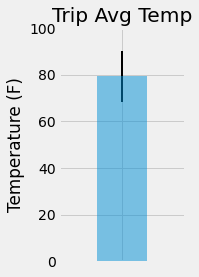

In [37]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize=(2, 4))
plt.bar(1, tavg, width=0.8, alpha=0.5, zorder=3)
plt.errorbar(1, tavg, yerr=[tmax-tmin], elinewidth=2, ecolor='black')
plt.ylabel('Temperature (F)')
plt.title('Trip Avg Temp')
plt.tick_params(bottom=False, labelbottom=False)
plt.xlim(0, 2)
plt.ylim(0, 100)
plt.grid(axis='y', zorder=1)
plt.show()

### Daily Rainfall Average

In [12]:
start_date = dt.date(2017, 8, 1).strftime('%Y-%m-%d')
end_date = dt.date(2017, 8, 7).strftime('%Y-%m-%d')
start_date, end_date

('2017-08-01', '2017-08-07')

In [13]:
# total amount of rainfall per weather station for trip dates using the previous year's matching dates.
# Sort in descending order by precipitation amount, list the station, name, latitude, longitude, and elevation
sel = [Measurement.station, func.sum(Measurement.prcp), Station.name, Station.latitude, Station.longitude, Station.elevation]
print('Station ID, Total Precipitation, Station Name, Station Latitude, Station Longitude, Station Elevation')
for row in session.query(*sel).filter(Measurement.station == Station.station, Measurement.date >= start_date, Measurement.date <= end_date).group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()):
    print(row)

Station ID, Total Precipitation, Station Name, Station Latitude, Station Longitude, Station Elevation
('USC00516128', 0.36, 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)
('USC00514830', 0.22, 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0)
('USC00519281', 0.06, 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9)
('USC00519397', 0.04, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0)
('USC00519523', 0.0, 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5)


In [14]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [15]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# create a range of dates covering the trip duration
dates = session.query(Measurement.date).filter(Measurement.date >=start_date, Measurement.date <=end_date).group_by(Measurement.date)
date_list = [x[0] for x in dates]
date_list

['2017-08-01',
 '2017-08-02',
 '2017-08-03',
 '2017-08-04',
 '2017-08-05',
 '2017-08-06',
 '2017-08-07']

In [16]:
# strip years from date list
date_list_md = [x[5:] for x in date_list]
date_list_md

['08-01', '08-02', '08-03', '08-04', '08-05', '08-06', '08-07']

In [17]:
# apply `daily_normals` for each date string
# append to list `normals`
normals = [daily_normals(x) for x in date_list_md]
normals

[[(67.0, 75.54, 83.0)],
 [(68.0, 75.60377358490567, 84.0)],
 [(70.0, 76.61111111111111, 85.0)],
 [(69.0, 76.71153846153847, 84.0)],
 [(69.0, 76.14814814814815, 82.0)],
 [(67.0, 76.25, 83.0)],
 [(71.0, 77.15686274509804, 83.0)]]

In [18]:
tmins = [x[0][0] for x in normals]
tavgs = [x[0][1] for x in normals]
tmaxs = [x[0][2] for x in normals]

In [19]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame({
    'date': date_list, 'tmin': tmins, 'tavg': tavgs, 'tmax': tmaxs
})
normals_df.set_index('date', inplace=True, drop=True)
normals_df

tmin       tavg  tmax
date                             
2017-08-01  67.0  75.540000  83.0
2017-08-02  68.0  75.603774  84.0
2017-08-03  70.0  76.611111  85.0
2017-08-04  69.0  76.711538  84.0
2017-08-05  69.0  76.148148  82.0
2017-08-06  67.0  76.250000  83.0
2017-08-07  71.0  77.156863  83.0

Text(0, 0.5, 'Temperature (F)')

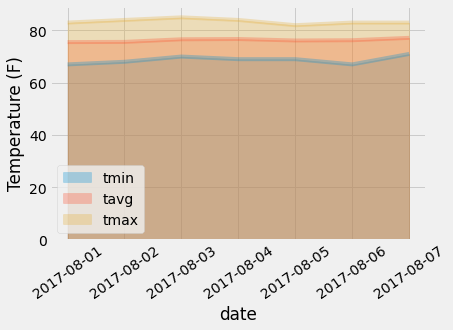

In [20]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot.area(stacked=False, rot=35, alpha=0.3)
plt.ylabel('Temperature (F)')

## Close Session

In [21]:
# Close Session
session.close()